In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
from sklearn.utils import shuffle
from tensorflow.keras.datasets.cifar10 import load_data
import tensorflow as tf

# Sometimes TF will spam WARNINGS, in order to shut it - set to print only errors
# tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import tensorflow.keras.layers as L

from typing import List, Optional

from .micro_child import MicroChild
from .micro_lstm import MicroLSTM

In [6]:
BATCH_SIZE = 160 # 160
SEED = None

(Xtrain, Ytrain), (Xtest, Ytest) = load_data()

Xtrain = Xtrain / 255
Xtest = Xtest / 255

Ytrain = Ytrain.astype(np.int32)
Ytest = Ytest.astype(np.int32)


def pre_process(x, cutout_size=None, seed=None):
    x = tf.pad(x, [[4, 4], [4, 4], [0, 0]])
    x = tf.image.random_crop(x, [32, 32, 3], seed=seed)
    x = tf.image.random_flip_left_right(x, seed=seed)
    if cutout_size is not None:
        mask = tf.ones([cutout_size, cutout_size], dtype=tf.int32)
        start = tf.random_uniform([2], minval=0, maxval=32, dtype=tf.int32)
        mask = tf.pad(mask, [[cutout_size + start[0], 32 - start[0]],
                           [cutout_size + start[1], 32 - start[1]]])
        mask = mask[cutout_size: cutout_size + 32,
                  cutout_size: cutout_size + 32]
        mask = tf.reshape(mask, [32, 32, 1])
        mask = tf.tile(mask, [1, 1, 3])
        x = tf.where(tf.equal(mask, 0), x=x, y=tf.zeros_like(x))
    return x


def data_generator(x_data, y_data, use_preprocess=True):
    assert len(x_data) == len(y_data)
    x_data, y_data = shuffle(x_data, y_data)
    counter = 0
    while True:
        yield (
            pre_process(x_data[counter]) if use_preprocess else x_data[counter], 
            y_data[counter]
        )
        counter += 1
        if counter == len(x_data):
            break

train_dataset = tf.data.Dataset.from_generator(
     lambda: data_generator(Xtrain, Ytrain),
     output_signature=(
         tf.TensorSpec(shape=(32, 32, 3), dtype=tf.float32),
         tf.TensorSpec(shape=(1,), dtype=tf.int32)
     )
)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_generator(
     lambda: data_generator(Xtest, Ytest, use_preprocess=False),
     output_signature=(
         tf.TensorSpec(shape=(32, 32, 3), dtype=tf.float32),
         tf.TensorSpec(shape=(1,), dtype=tf.int32)
     )
)
test_dataset = test_dataset.batch(BATCH_SIZE)

iterations_per_epoch = len(Xtrain)//BATCH_SIZE

In [7]:
iter_train_dataset = iter(train_dataset)
x,y=next(iter_train_dataset)

In [9]:
micro_lstm = MicroLSTM(
    num_branches=5, num_cells=5, lstm_size=64, # temperature=5.0, 
    tanh_constant=1.1, entropy_weight=0.0001,
    op_tanh_reduce=2.5, decay=0.99
)

In [10]:
opt_nas = tf.keras.optimizers.SGD(
    learning_rate=tf.keras.optimizers.schedules.CosineDecayRestarts(
        0.05, first_decay_steps=iterations_per_epoch * 10, 
        t_mul=2, m_mul=1, alpha=5e-4
    ),
    momentum=0.9, nesterov=True
)
"""
opt_nas = tf.keras.optimizers.Adam(
    learning_rate=tf.keras.optimizers.schedules.CosineDecayRestarts(
        0.05, first_decay_steps=iterations_per_epoch * 10, 
        t_mul=2, m_mul=1, alpha=5e-4
    ),
    beta_1=0.0, epsilon=1e-3
)
"""

'\nopt_nas = tf.keras.optimizers.Adam(\n    learning_rate=tf.keras.optimizers.schedules.CosineDecayRestarts(\n        0.05, first_decay_steps=iterations_per_epoch * 10, \n        t_mul=2, m_mul=1, alpha=5e-4\n    ),\n    beta_1=0.0, epsilon=1e-3\n)\n'

In [11]:
opt_controller = tf.keras.optimizers.Adam(
    learning_rate=0.0035, 
    beta_1=0.0, # beta_1=0.0, 0.1 
    epsilon=1e-3
)

In [12]:
micro_child = MicroChild(
    input_shape=(32, 32, 3),
    nas_controller=micro_lstm,
    opt_nas=opt_nas,
    opt_controller=opt_controller,
    num_cells=5, num_layers=6, out_filters=20, # 48
    keep_prob=0.9, drop_path_keep_prob=0.6,
    # l2_reg=1e-4, # TODO: Look at the comment inside this module how to fix it
    use_aux_heads=True, clip_mode=ClipGradsMode.NORM
)

MicroNasModel configured to be dynamic-builded. 
Use additional aux-head for training in layer_id=6


In [13]:
micro_child.fit_controller(
    train_dataset, test_dataset, 
    steps_per_epoch_for_model=iterations_per_epoch,
    num_epochs_for_model=1, num_epoch_for_controller=30, 
    epochs=50
)

  0%|          | 0/312 [00:00<?, ?it/s]

Epoch=1/50
Train nas-model...


  0%|          | 0/312 [00:21<?, ?it/s]


InvalidArgumentError: {{function_node __wrapped__Unique_device_/job:localhost/replica:0/task:0/device:GPU:0}} unique expects a 1D vector. [Op:Unique]

# Debug stuff
Below you can find some stuff for debug created models

In [16]:
num_cells=5

In [25]:
test_arr = [
    # First index - layer_id
    [  # Second index - branch id 
        [ # Third index - prev_cell (id)
            [None] * NASLayer.COUNT_OP # Fourth index - op_id
        ] * (i + 2)
        for i in range(num_cells)
    ] * NASCellTypeV1.SIZE
] * num_cells
len(test_arr)

5

In [29]:
test_arr = [None] * num_cells
for i in range(num_cells):
    test_arr[i] = [  
        # Second index - branch id 
        [ # Third index - prev_cell (id)
            [None] * NASLayer.COUNT_OP # Fourth index - op_id
        ] * (i + 2)
    ] * NASCellTypeV1.SIZE

In [30]:
for arr in test_arr:
    print(arr)
    print()

[[[None, None, None, None, None], [None, None, None, None, None]], [[None, None, None, None, None], [None, None, None, None, None]]]

[[[None, None, None, None, None], [None, None, None, None, None], [None, None, None, None, None]], [[None, None, None, None, None], [None, None, None, None, None], [None, None, None, None, None]]]

[[[None, None, None, None, None], [None, None, None, None, None], [None, None, None, None, None], [None, None, None, None, None]], [[None, None, None, None, None], [None, None, None, None, None], [None, None, None, None, None], [None, None, None, None, None]]]

[[[None, None, None, None, None], [None, None, None, None, None], [None, None, None, None, None], [None, None, None, None, None], [None, None, None, None, None]], [[None, None, None, None, None], [None, None, None, None, None], [None, None, None, None, None], [None, None, None, None, None], [None, None, None, None, None]]]

[[[None, None, None, None, None], [None, None, None, None, None], [None, None, N

In [26]:
for arr in test_arr:
    print(arr)
    print()

[[[None, None, None, None, None], [None, None, None, None, None]], [[None, None, None, None, None], [None, None, None, None, None], [None, None, None, None, None]], [[None, None, None, None, None], [None, None, None, None, None], [None, None, None, None, None], [None, None, None, None, None]], [[None, None, None, None, None], [None, None, None, None, None], [None, None, None, None, None], [None, None, None, None, None], [None, None, None, None, None]], [[None, None, None, None, None], [None, None, None, None, None], [None, None, None, None, None], [None, None, None, None, None], [None, None, None, None, None], [None, None, None, None, None]], [[None, None, None, None, None], [None, None, None, None, None]], [[None, None, None, None, None], [None, None, None, None, None], [None, None, None, None, None]], [[None, None, None, None, None], [None, None, None, None, None], [None, None, None, None, None], [None, None, None, None, None]], [[None, None, None, None, None], [None, None, None, Non

In [22]:
len([None] * num_cells)

5

In [12]:
model = micro_child.model

In [13]:
len(model.enas_layers_dict['0']['normal-layer']._enas_cells_created_list)

25

In [14]:
part_list = model.enas_layers_dict['0']['normal-layer']._enas_cells_created_list[8][0]
len(part_list), part_list

(5,
 ListWrapper([ListWrapper([<__main__.StackedLayers object at 0x7f46881233d0>, <__main__.StackedLayers object at 0x7f46881072e0>, <__main__.StackedLayers object at 0x7f468812d2b0>, <__main__.StackedLayers object at 0x7f468812da90>, <__main__.StackedLayers object at 0x7f468812d580>]), ListWrapper([<__main__.StackedLayers object at 0x7f46881233d0>, <__main__.StackedLayers object at 0x7f46881072e0>, <__main__.StackedLayers object at 0x7f468812d2b0>, <__main__.StackedLayers object at 0x7f468812da90>, <__main__.StackedLayers object at 0x7f468812d580>]), ListWrapper([<__main__.StackedLayers object at 0x7f46881233d0>, <__main__.StackedLayers object at 0x7f46881072e0>, <__main__.StackedLayers object at 0x7f468812d2b0>, <__main__.StackedLayers object at 0x7f468812da90>, <__main__.StackedLayers object at 0x7f468812d580>]), ListWrapper([<__main__.StackedLayers object at 0x7f46881233d0>, <__main__.StackedLayers object at 0x7f46881072e0>, <__main__.StackedLayers object at 0x7f468812d2b0>, <__mai

In [15]:
[(len(p), None in p) for p in part_list]

[(5, False), (5, False), (5, False), (5, False), (5, False)]

In [55]:
len(model.enas_layers_dict['0']['normal-layer']._enas_cells_created_list)

25

In [53]:
part_list = model.enas_layers_dict['0']['normal-layer']._enas_cells_created_list[8][0]
len(part_list), part_list

(5,
 ListWrapper([ListWrapper([<__main__.StackedLayers object at 0x7fd5206d5fa0>, <__main__.StackedLayers object at 0x7fd5206d5040>, <__main__.StackedLayers object at 0x7fd5206d5ca0>, <__main__.StackedLayers object at 0x7fd5206bc7c0>, <__main__.StackedLayers object at 0x7fd5206d5af0>]), ListWrapper([<__main__.StackedLayers object at 0x7fd5206d5fa0>, <__main__.StackedLayers object at 0x7fd5206d5040>, <__main__.StackedLayers object at 0x7fd5206d5ca0>, <__main__.StackedLayers object at 0x7fd5206bc7c0>, <__main__.StackedLayers object at 0x7fd5206d5af0>]), ListWrapper([<__main__.StackedLayers object at 0x7fd5206d5fa0>, <__main__.StackedLayers object at 0x7fd5206d5040>, <__main__.StackedLayers object at 0x7fd5206d5ca0>, <__main__.StackedLayers object at 0x7fd5206bc7c0>, <__main__.StackedLayers object at 0x7fd5206d5af0>]), ListWrapper([<__main__.StackedLayers object at 0x7fd5206d5fa0>, <__main__.StackedLayers object at 0x7fd5206d5040>, <__main__.StackedLayers object at 0x7fd5206d5ca0>, <__mai

In [54]:
[(len(p), None in p) for p in part_list]

[(5, False), (5, False), (5, False), (5, False), (5, False)]

In [12]:
micro_lstm.baseline

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>

In [13]:
y_pred, y_aux_pred_list = micro_child.model(
    x_input, 
    normal_arc=normal_arc, reduce_arc=reduce_arc, 
    training=True
)  # Forward pass

NameError: name 'x_input' is not defined

In [ ]:
predictions = tf.argmax(y_pred, axis=-1, output_type=tf.int32)
reward = tf.equal(y_true, predictions)
reward = tf.reduce_mean(tf.cast(reward, dtype=tf.float32))
reward

In [ ]:
sample_entropy, sample_log_prob

In [ ]:
micro_lstm.calculate_loss()

In [15]:
x,y=next(iter_train_dataset)

In [16]:
data = (x,y)

In [17]:
x_input, y_true = data
normal_arc, reduce_arc = None, None
if micro_child.fixed_arc is None:
    (normal_arc, reduce_arc), _, _, _, _ = micro_child.nas_controller.calculate_entropy()
else:
    # TODO: Parse fixed arc?
    pass

In [36]:
with tf.GradientTape() as tape:
    y_pred, y_aux_pred_list = micro_child.model(
        x_input, 
        normal_arc=normal_arc, reduce_arc=reduce_arc, 
        training=True
    )  # Forward pass
    # Compute the loss value
    # (the loss function is configured in `compile()`)
    losses = micro_child.model.losses
    print(tf.reduce_mean(losses))
    loss = micro_child.model.compiled_loss(y_true, y_pred, regularization_losses=losses)
    if y_aux_pred_list is not None and len(y_aux_pred_list) > 0:
        aux_loss = 0.0
        for y_aux_head_s in y_aux_pred_list:
            aux_loss += micro_child.model.compiled_loss(y_true, y_aux_head_s)
        loss += micro_child.model.aux_scale * aux_loss
loss

tf.Tensor(nan, shape=(), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=3.5360575>

In [37]:
# Compute gradients
gradients = tape.gradient(loss, micro_child.model.trainable_variables)
# Remove gradients which are None aka not used with current normal/reduce arc
checked_gradients = []
checked_trainable_vars = []
for gr, tr_var in zip(gradients, micro_child.model.trainable_variables):
    # TODO: Is `gr` also None then using tf.function for layers? Need to test it!
    if gr is not None:
        if micro_child.clip_mode is not None and micro_child.clip_mode == ClipGradsMode.NORM:
            assert micro_child.grad_bound_nas_model, "Need grad_bound to clip gradients."
            # TODO: Is this if-else needed?
            if isinstance(gr, tf.IndexedSlices):
                c_g = tf.clip_by_norm(gr.values, micro_child.grad_bound_nas_model)
                c_g = tf.IndexedSlices(gr.indices, c_g, dense_shape=tf.shape(tr_var))
            else:
                c_g = tf.clip_by_norm(gr, micro_child.grad_bound_nas_model)
            gr = c_g
        checked_gradients.append(gr)
        checked_trainable_vars.append(tr_var)
# TODO: Test it!
if micro_child.clip_mode is not None:
    assert micro_child.grad_bound_nas_model, "Need grad_bound to clip gradients."
    if micro_child.clip_mode == ClipGradsMode.GLOBAL:
        checked_gradients, _ = tf.clip_by_global_norm(checked_gradients, micro_child.grad_bound_nas_model)
    elif micro_child.clip_mode == ClipGradsMode.NORM:
        # Applied above
        pass
    else:
        raise NotImplementedError("Unknown clip_mode {}".format(self.clip_mode))
len(checked_gradients)

428

In [38]:
[(ch_g.shape, v.shape) for ch_g, v in zip(checked_gradients, checked_trainable_vars)]

[(TensorShape([60]), TensorShape([60])),
 (TensorShape([60]), TensorShape([60])),
 (TensorShape([3, 3, 3, 60]), TensorShape([3, 3, 3, 60])),
 (TensorShape([20]), TensorShape([20])),
 (TensorShape([20]), TensorShape([20])),
 (TensorShape([3, 3, 20, 1]), TensorShape([3, 3, 20, 1])),
 (TensorShape([1, 1, 20, 20]), TensorShape([1, 1, 20, 20])),
 (TensorShape([20]), TensorShape([20])),
 (TensorShape([20]), TensorShape([20])),
 (TensorShape([3, 3, 20, 1]), TensorShape([3, 3, 20, 1])),
 (TensorShape([1, 1, 20, 20]), TensorShape([1, 1, 20, 20])),
 (TensorShape([20]), TensorShape([20])),
 (TensorShape([20]), TensorShape([20])),
 (TensorShape([3, 3, 20, 1]), TensorShape([3, 3, 20, 1])),
 (TensorShape([1, 1, 20, 20]), TensorShape([1, 1, 20, 20])),
 (TensorShape([20]), TensorShape([20])),
 (TensorShape([20]), TensorShape([20])),
 (TensorShape([3, 3, 20, 1]), TensorShape([3, 3, 20, 1])),
 (TensorShape([1, 1, 20, 20]), TensorShape([1, 1, 20, 20])),
 (TensorShape([20]), TensorShape([20])),
 (TensorSh

In [34]:
gradients[2] is not None

True

In [18]:
[(float(tf.reduce_mean(g).numpy()), t_v.name) for g, t_v in zip(gradients, trainable_vars)]

ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

In [44]:
found_g = []
for g, t_v in zip(gradients, trainable_vars):
    if 'dynamic_inputs_' in t_v.name:
        print(len(found_g), float(tf.reduce_mean(g).numpy()), t_v.name)
        found_g.append(g)

0 -9.277481149183586e-05 dynamic_inputs_conv/kernel:0
1 -2.073124051094055e-06 dynamic_inputs_bn/gamma:0
2 0.002038371516391635 dynamic_inputs_bn/beta:0
3 -0.00037956019514240324 dynamic_inputs_conv/kernel:0
4 -1.4942139614504413e-06 dynamic_inputs_bn/gamma:0
5 3.9041043464749237e-07 dynamic_inputs_bn/beta:0
6 -5.117017281008884e-05 dynamic_inputs_conv/kernel:0
7 2.9209162676124834e-05 dynamic_inputs_bn/gamma:0
8 0.0010020241606980562 dynamic_inputs_bn/beta:0
9 -1.6010528270271607e-05 dynamic_inputs_conv/kernel:0
10 8.332589459314477e-06 dynamic_inputs_bn/gamma:0
11 0.0005863040569238365 dynamic_inputs_bn/beta:0
12 1.0485095117473975e-05 dynamic_inputs_conv/kernel:0
13 -4.3222681256338547e-07 dynamic_inputs_bn/gamma:0
14 1.4901161193847656e-07 dynamic_inputs_bn/beta:0
15 -2.612958269310184e-06 dynamic_inputs_conv/kernel:0
16 1.4242134056985378e-05 dynamic_inputs_bn/gamma:0
17 0.00016833438712637872 dynamic_inputs_bn/beta:0
18 1.639735046410351e-06 dynamic_inputs_conv/kernel:0
19 -4.402

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

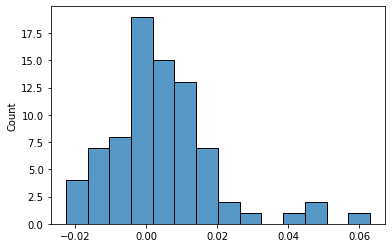

In [51]:
# for bn
g_ex = found_g[22]

_ = sns.histplot(g_ex)

In [52]:
# for conv
g_ex = found_g[21]
shape = tf.shape(g_ex)
in_f = out_f = tf.cast(tf.sqrt(tf.cast(shape[1], dtype=tf.float32)), dtype=tf.int32)
g_ex = tf.reshape(g_ex, (shape[0], 1, 1, in_f, out_f))
g_ex.shape

TensorShape([7, 1, 1, 80, 80])

Figure=0, mean=0.0
Figure=1, mean=0.0
Figure=2, mean=0.0
Figure=3, mean=0.0
Figure=4, mean=0.0
Figure=5, mean=4.2916264646919444e-05
Figure=6, mean=3.550735709723085e-05


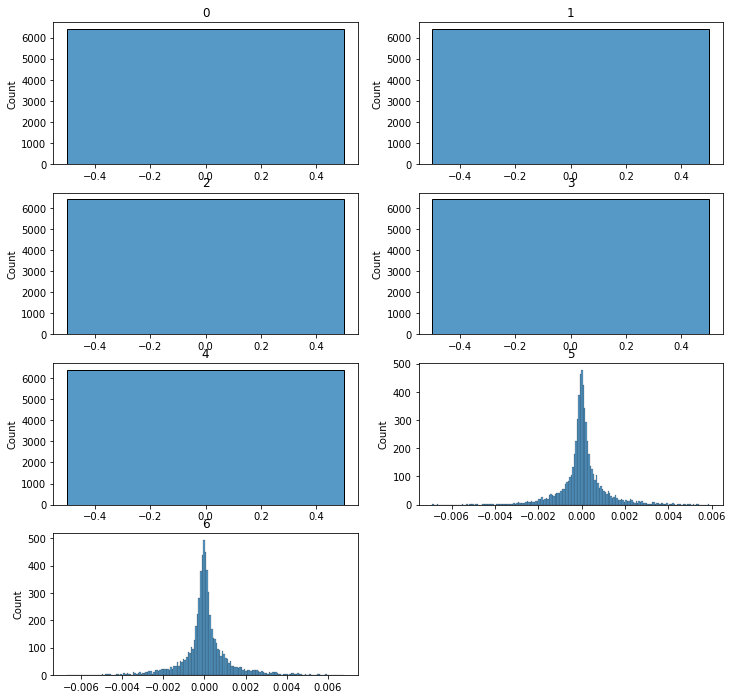

In [53]:
fig = plt.figure(figsize=(12,12))

for i in range(7):
    plt.subplot(4, 2, i+1)
    g_data = g_ex[i].numpy().reshape(-1)
    sns.histplot(g_data)
    print(f'Figure={i}, mean={g_data.mean()}')
    plt.title(i)

In [49]:
import seaborn as sns

In [50]:
gr_mean = np.asarray([float(tf.reduce_mean(g).numpy()) for g, t_v in zip(gradients, trainable_vars)])
gr_mean.max(), gr_mean.min()

(0.0029549121391028166, -0.00635257363319397)

<ipython-input-51-3bc923061942>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(gr_mean)


<Axes: ylabel='Density'>

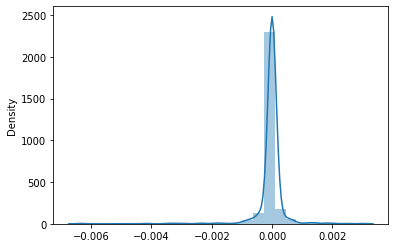

In [51]:
sns.distplot(gr_mean)

In [ ]:
# Update weights
micro_child.model.optimizer.apply_gradients(zip(gradients, trainable_vars))

In [17]:
y_pred, y_aux_pred_list = micro_child.model(
    x_input, 
    normal_arc=normal_arc, reduce_arc=reduce_arc, 
    training=True
)  # Forward pass

In [13]:
tf.reduce_sum(micro_child.model.losses)

<tf.Tensor: shape=(), dtype=float32, numpy=1.7167526>

In [50]:
for i1 in range(len(micro_child.model.enas_layers_dict['0']['normal-layer']._enas_cells_created_list)):
    l1_list = micro_child.model.enas_layers_dict['0']['normal-layer']._enas_cells_created_list[i1]
    for i2 in range(len(l1_list)):
        l2_list = l1_list[i2]
        for i3 in range(len(l2_list)):
            l3_list = l2_list[i3]
            for i4 in range(len(l3_list)):
                l4_stacked = l3_list[i4]
                for layer_i in l4_stacked.layers:
                    if isinstance(layer_i, ConvBn):
                        print(i1, i2, i3, i4)

In [22]:
micro_child.model.enas_layers_dict['0']['normal-layer']._enas_cells_created_list[0][0][-2][3].layers

ListWrapper([<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f420281c340>])

In [23]:
micro_child.model.enas_layers_dict['0']['normal-layer']._enas_cells_created_list[0][0][0][0].layers[1].sep_conv

In [19]:
micro_child.model.enas_layers_dict['0']['normal-layer']._enas_cells_created_list[0][0][0][0].layers[1].losses

[]

In [24]:
micro_child.model.enas_layers_dict['0']['normal-layer']._enas_cells_created_list[0][0][0][0].layers[1].sep_conv.get_config()

{'name': 'separable_conv2d_332',
 'trainable': True,
 'dtype': 'float32',
 'filters': 20,
 'kernel_size': (5, 5),
 'strides': (1, 1),
 'padding': 'same',
 'data_format': 'channels_last',
 'dilation_rate': (1, 1),
 'groups': 1,
 'activation': 'linear',
 'use_bias': False,
 'kernel_initializer': {'class_name': 'GlorotUniform',
  'config': {'seed': None}},
 'bias_initializer': None,
 'kernel_regularizer': None,
 'bias_regularizer': {'class_name': 'L2',
  'config': {'l2': 9.999999747378752e-05}},
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None,
 'depth_multiplier': 1,
 'depthwise_initializer': {'class_name': 'GlorotUniform',
  'config': {'seed': None}},
 'pointwise_initializer': {'class_name': 'GlorotUniform',
  'config': {'seed': None}},
 'depthwise_regularizer': {'class_name': 'L2',
  'config': {'l2': 9.999999747378752e-05}},
 'pointwise_regularizer': {'class_name': 'L2',
  'config': {'l2': 9.999999747378752e-05}},
 'depthwise_constraint': None,
 'poin

In [16]:
test_iter = iter(test_dataset.repeat())
accuracy_calc = tf.keras.metrics.Accuracy()

In [45]:
(normal_arc, reduce_arc), _, _ = micro_child.nas_controller.calculate_entropy()

x_data, y_data = next(test_iter)
predictions, _ = micro_child.model(
    x_data, 
    normal_arc=normal_arc, reduce_arc=reduce_arc, 
    training=True # TODO: True is right here?
)
predictions = tf.argmax(predictions, axis=-1)
accuracy_calc.reset_state()
accuracy_calc.update_state(y_data, predictions)
reward = accuracy_calc.result()
reward = tf.stop_gradient(reward)

In [46]:
reward

<tf.Tensor: shape=(), dtype=float32, numpy=0.13125>

In [47]:
with tf.GradientTape() as tape:
    loss, reward = micro_child.nas_controller.calculate_loss(reward, training=True)

In [48]:
grads = tape.gradient(loss, micro_child.nas_controller.trainable_variables)

In [49]:
[(float(tf.reduce_mean(g).numpy()), v.name) for (g, v) in zip(grads, micro_child.nas_controller.trainable_variables)]

[(0.01846197247505188, 'b-soft:0'),
 (5.662335752276704e-05, 'g-emb:0'),
 (0.00010873021528823301, 'att-v:0'),
 (-4.0373511183133814e-06, 'att-w-1:0'),
 (-5.088034438216482e-09, 'att-w-2:0'),
 (-2.1859452317585237e-05, 'w-emb:0'),
 (-7.929662388050929e-05, 'w-soft:0'),
 (-3.0071714718360454e-07, 'lstm/lstm_cell/kernel:0'),
 (3.378854671609588e-07, 'lstm/lstm_cell/recurrent_kernel:0'),
 (-6.085422864998691e-05, 'lstm/lstm_cell/bias:0'),
 (-6.582453693226853e-08, 'lstm_1/lstm_cell_1/kernel:0'),
 (-6.582453693226853e-08, 'lstm_1/lstm_cell_1/recurrent_kernel:0'),
 (-7.285163155756891e-05, 'lstm_1/lstm_cell_1/bias:0')]

In [ ]:
self.opt_controller.apply_gradients(zip(grads, self.nas_controller.trainable_variables))

In [24]:
accuracy_calc = tf.keras.metrics.Accuracy()

In [25]:
data_gen = iter(test_dataset.repeat())

In [30]:
(normal_arc, reduce_arc), _, _ = micro_child.nas_controller.calculate_entropy()

x_data, y_data = next(data_gen)
predictions, _ = micro_child.model(
    x_data, 
    normal_arc=normal_arc, reduce_arc=reduce_arc, 
    training=True # TODO: True is right here?
)

In [32]:
predictions = tf.argmax(predictions, axis=-1)
predictions.shape, y_data.shape

(TensorShape([160]), TensorShape([160, 1]))

In [ ]:
accuracy_calc.reset_state()
accuracy_calc.update_state(y_data, predictions)
reward = accuracy_calc.result()
loss, reward = self.single_step_nas_controller(reward)

In [ ]:
# 24 no-tf-func
#  tf-func

In [20]:
vvv = micro_child.model.weights

In [21]:
len(vvv)

3697

In [24]:
micro_child.model._get_layer(2, NASLayerType.REDUCTION_LAYER)

In [21]:
micro_child.model.pool_layers

ListWrapper([2, 5])

In [17]:
dict(np.load('weights/shared_weights_for_0/0_enascell_x_5.npz'))['w_depthwise'].shape

(2, 500)

In [17]:
(normal_arc, reduce_arc), entr, log = micro_lstm.calculate_entropy()
normal_arc = normal_arc.numpy()
reduce_arc = reduce_arc.numpy()
normal_arc[::2], reduce_arc[::2]

(array([0, 1, 1, 2, 2, 2, 2, 2, 1, 4], dtype=int32),
 array([1, 0, 0, 1, 3, 2, 1, 0, 4, 0], dtype=int32))

In [19]:
# Some loss error with this config...
normal_arc = [1,1,1,1,1,1,2,0,1,1,2,1,3,0,1,0,4,0,1,0,2,1,5,0]
reduce_arc = [1,1,1,0,2,2,0,0,1,4,2,0,2,0,2,0,1,1,2,1,4,1,2,0]

In [19]:
model = MicroNasModel(
    normal_arc=normal_arc, reduce_arc=reduce_arc, data_input_shape=(32, 32, 3), 
    num_layers=6, 
    num_cells=5, out_filters=20, 
    #keep_prob=0.9, 
    #drop_path_keep_prob=0.6, 
    global_step=tf.Variable(0, trainable=False),
    path_to_store_shared='./weights', use_aux_heads=True
)

[TensorShape([1, 32, 32, 60]), TensorShape([1, 32, 32, 60])]
[TensorShape([1, 32, 32, 60]), TensorShape([1, 32, 32, 60])]
[TensorShape([1, 32, 32, 60]), TensorShape([1, 16, 16, 40])]
[TensorShape([1, 16, 16, 40]), TensorShape([1, 16, 16, 80])]
[TensorShape([1, 16, 16, 80]), TensorShape([1, 16, 16, 120])]
[TensorShape([1, 16, 16, 120]), TensorShape([1, 8, 8, 80])]
[TensorShape([1, 8, 8, 80]), TensorShape([1, 8, 8, 160])]
[TensorShape([1, 8, 8, 160]), TensorShape([1, 8, 8, 240])]


In [18]:
training = True
out_x, out_aux_head_x = model(x, training=training)
out_x.shape, x.shape, out_x[0]

(TensorShape([160, 10]),
 TensorShape([160, 32, 32, 3]),
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([ -67.20114 ,  213.165   , -159.1188  ,   47.12942 ,  -53.963524,
         -54.65165 ,   36.38561 ,  -60.508736,  -49.553017, -106.116516],
       dtype=float32)>)

In [19]:
# TODO: Should some variables will be transferred from older optimizer?
opt_nas = micro_child.call_create_opt_nas()
model.compile(opt_nas, loss=micro_child.loss, metrics='accuracy', run_eagerly=False)

In [20]:
loss = model.train_step((x,y))

Compute aug-head loss!


In [21]:
model.losses

[]

In [22]:
loss

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=95.54731>,
 'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.11875>}

In [68]:
stem_x = model.stem_conv(x, training=training)
stem_x.shape, stem_x[0, 0, 0, :10]

(TensorShape([160, 32, 32, 60]),
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([ 5.3995509e-02, -5.7827290e-02, -4.2014830e-02, -3.0631887e-02,
        -1.5955178e-04,  6.8952799e-02,  1.3793041e-01,  1.6407149e-01,
        -7.6055050e-02,  1.2029748e-01], dtype=float32)>)

In [70]:
layers = [stem_x, stem_x]

In [71]:
normal1 = model._get_layer(
        0, NASLayerType.NORMAL_LAYER,
    )
x_t = normal1(layers, training=training)
tf.reduce_mean(x_t)

<tf.Tensor: shape=(), dtype=float32, numpy=nan>

In [75]:
prev_layers = layers

In [76]:
prev_tensors: List[tf.Tensor] = list(normal1.calibrate_size_layer(
    *prev_layers, training=training
))

In [79]:
[tf.reduce_mean(l_s) for l_s in prev_tensors]

[<tf.Tensor: shape=(), dtype=float32, numpy=-0.0013113822>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.015026496>]

In [80]:
used = []
for cell_id in range(normal1.num_cells):
    x_id = normal1.arc[4 * cell_id]
    x_op = normal1.arc[4 * cell_id + 1]
    x = tf.gather(prev_tensors, x_id) # prev_tensors[x_id]
    x = normal1._run_enas_cell(
        x, cell_id, x_id, x_op, normal1.out_filters, 
        cell_type=NASCellType.X_TYPE, training=training
    )

    y_id = normal1.arc[4 * cell_id + 2]
    y_op = normal1.arc[4 * cell_id + 3]
    y = tf.gather(prev_tensors, y_id) # prev_tensors[y_id]
    y = normal1._run_enas_cell(
        y, cell_id, y_id, y_op, normal1.out_filters, 
        cell_type=NASCellType.Y_TYPE, training=training
    )

    merge_out = x + y
    prev_tensors.append(merge_out)

    used.extend([
        tf.one_hot(x_id, depth=normal1.num_cells + 2, dtype=tf.int32),
        tf.one_hot(y_id, depth=normal1.num_cells + 2, dtype=tf.int32)
    ])

In [ ]:
[tf.reduce_mean(l_s) for l_s in prev_tensors]

In [83]:
cell_id = 2

In [84]:
x_id = normal1.arc[4 * cell_id]
x_op = normal1.arc[4 * cell_id + 1]
x = tf.gather(prev_tensors, x_id) # prev_tensors[x_id]
x = normal1._run_enas_cell(
    x, cell_id, x_id, x_op, normal1.out_filters, 
    cell_type=NASCellType.X_TYPE, training=training
)

In [86]:
prev_created = normal1.get_enas_cell(
    cell_id, x_id, NASCellType.X_TYPE, x_op, normal1.out_filters
)

In [91]:
prev_created.layers[1].sep_conv.get_weights()

[array([[[[nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan]],
 
         [[nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan]],
 
         [[nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan],
          [nan],
        

In [85]:
tf.reduce_mean(x)

<tf.Tensor: shape=(), dtype=float32, numpy=nan>

In [67]:
layers = [stem_x, stem_x]

aux_result_tensors_list = []
for layer_id in range(model.num_layers + 2):
    if layer_id in model.pool_layers:
        x_t = model._get_layer(
            layer_id, NASLayerType.REDUCTION_LAYER,
        )(x_t, training=training)
        layers = [layers[-1], x_t]
        print(f'reduction {layer_id} = {tf.reduce_mean(x_t)}')
    x_t = model._get_layer(
        layer_id, NASLayerType.NORMAL_LAYER,
    )(layers, training=training)
    layers = [layers[-1], x_t]
    print(f'normal {layer_id} = {tf.reduce_mean(x_t)}')

    if model.use_aux_heads and layer_id in model.aux_head_indices and training:
        aux_result_tensors_list += [
            model._get_layer(
                layer_id, NASLayerType.AUX_LAYER
            )(x_t, training=training)
        ]
x_t.shape, tf.reduce_mean(x_t)

normal 0 = nan
normal 1 = nan
reduction 2 = nan
normal 2 = nan
normal 3 = nan
normal 4 = nan
reduction 5 = nan
normal 5 = nan
normal 6 = nan
normal 7 = nan


(TensorShape([160, 8, 8, 80]), <tf.Tensor: shape=(), dtype=float32, numpy=nan>)

In [46]:
tf.argmax(tf.math.softmax(out_x, axis=-1), axis=-1)

<tf.Tensor: shape=(160,), dtype=int64, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])>

In [47]:
out_x[:2]

<tf.Tensor: shape=(2, 10), dtype=float32, numpy=
array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]], dtype=float32)>

In [27]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [28]:
loss(y, out_x)

<tf.Tensor: shape=(), dtype=float32, numpy=nan>

In [23]:
prev_c=None
prev_h=None
use_bias=False
training=False
# TODO: Rewrite it to
#           https://github.com/google-research/google-research/blob/698c1a53af550cf29becdb08e1c1b2f0a507dd46/enas_lm/src/controller.py#L116
# Good example on torch:
#           https://github.com/MengTianjian/enas-pytorch/blob/master/micro_controller.py
arc_seq, sample_log_probs, sample_entropy = [], [], []
all_h = [tf.zeros([1, micro_lstm.lstm_size], dtype=tf.float32)]
all_h_w = [tf.zeros([1, micro_lstm.lstm_size], dtype=tf.float32)]
inputs = tf.expand_dims(micro_lstm.g_emb, axis=0)
for layer_id in range(micro_lstm.num_generated_cells):
    _, next_c, next_h = micro_lstm.call_lstm(
        inputs, prev_h=prev_h, prev_c=prev_c, training=training
    )
    prev_c, prev_h = next_c, next_h
    all_h.append(tf.zeros_like(next_h)) # next_h or zeros with shape as next_h ???
    all_h_w.append(
        tf.matmul(next_h, micro_lstm.w_attn_1)
    )

In [24]:
layer_id = 2

In [71]:
layer_id < (micro_lstm.num_cells + 2)

True

In [72]:
# Operation
_, next_c, next_h = micro_lstm.call_lstm(
   inputs, prev_h=prev_h, prev_c=prev_c, training=training
)
# prev_c, prev_h = next_c, next_h
logits = tf.matmul(next_h, micro_lstm.w_soft) + micro_lstm.b_soft
if micro_lstm.temperature is not None:
    logits /= micro_lstm.temperature
if micro_lstm.tanh_constant is not None:
    logits = micro_lstm.tanh_constant * tf.tanh(logits)
if use_bias:
    logits += micro_lstm.b_soft_not_learned
op_id = tf.random.categorical(logits, 1)
op_id = tf.cast(op_id, dtype=tf.int32)
op_id = tf.reshape(op_id, [])
op_id

<tf.Tensor: shape=(), dtype=int32, numpy=1>

In [73]:
arc_seq_cell = [None] * 4
prev_layers = []
for cell_i in range(2):
    _, next_c, next_h = micro_lstm.call_lstm(
        inputs, prev_h=prev_h, prev_c=prev_c, training=training
    )
    prev_c, prev_h = next_c, next_h
    query = tf.tanh(
        tf.concat(all_h_w[:layer_id], axis=0) + tf.matmul(next_h, micro_lstm.w_attn_2)
    )
    logits = tf.matmul(query, micro_lstm.v_attn)
    logits = tf.reshape(logits, [1, layer_id])
    if micro_lstm.temperature is not None:
        logits /= micro_lstm.temperature
    if micro_lstm.tanh_constant is not None:
        logits = micro_lstm.tanh_constant * tf.tanh(logits)

    skip_index = tf.random.categorical(logits, 1)
    skip_index = tf.cast(skip_index, dtype=tf.int32)
    skip_index = tf.reshape(skip_index, [])
    arc_seq_cell[cell_i * 2] = skip_index

    log_prob = tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=tf.reshape(skip_index, [1])
    )
    sample_log_probs.append(log_prob)

    entropy = log_prob * tf.exp(-log_prob)
    sample_entropy.append(entropy)

    prev_layers.append(all_h[skip_index])
    inputs = tf.expand_dims(prev_layers[-1], axis=0)

In [74]:
arc_seq_cell

[<tf.Tensor: shape=(), dtype=int32, numpy=0>,
 None,
 <tf.Tensor: shape=(), dtype=int32, numpy=3>,
 None]

In [75]:
for op_i in range(2):
    # Operation
    _, next_c, next_h = micro_lstm.call_lstm(
       inputs, prev_h=prev_h, prev_c=prev_c, training=training
    )
    prev_c, prev_h = next_c, next_h
    logits = tf.matmul(next_h, micro_lstm.w_soft) + micro_lstm.b_soft
    if micro_lstm.temperature is not None:
        logits /= micro_lstm.temperature
    if micro_lstm.tanh_constant is not None:
        logits = micro_lstm.tanh_constant * tf.tanh(logits)
    if use_bias:
        logits += micro_lstm.b_soft_not_learned
    op_id = tf.random.categorical(logits, 1)
    op_id = tf.cast(op_id, dtype=tf.int32)
    op_id = tf.reshape(op_id, [])
    arc_seq_cell[op_i * 2 + 1] = op_id
    log_prob = tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=tf.reshape(op_id, [1])
    )
    sample_log_probs.append(log_prob)
    entropy = log_prob * tf.exp(-log_prob)
    sample_entropy.append(entropy)
    inputs = tf.expand_dims(tf.expand_dims(
        tf.nn.embedding_lookup(micro_lstm.w_emb, op_id), 
        axis=0 ), axis=0
    )            

In [76]:
arc_seq_cell

[<tf.Tensor: shape=(), dtype=int32, numpy=0>,
 <tf.Tensor: shape=(), dtype=int32, numpy=4>,
 <tf.Tensor: shape=(), dtype=int32, numpy=3>,
 <tf.Tensor: shape=(), dtype=int32, numpy=0>]

In [77]:
_, next_c, next_h = micro_lstm.call_lstm(
    inputs, prev_h=prev_h, prev_c=prev_c, training=training
)
arc_seq += arc_seq_cell
all_h.append(next_h)
all_h_w.append(tf.matmul(next_h, micro_lstm.w_attn_1))
inputs = tf.expand_dims(micro_lstm.g_emb, axis=0)
layer_id +=1

In [ ]:
x,y=next(iter(train_dataset))

In [ ]:
micro_child.model(x)
micro_child.model.fit(x,y, batch_size=160)

In [ ]:
loss, reward = micro_child.single_step_nas_controller(tf.convert_to_tensor(0.62))

In [ ]:
micro_lstm.trainable_variables

In [ ]:
ttt = tf.random.uniform(shape=(160, 32, 32, 20))
ttt.shape

In [ ]:
nas_layer = NASLayer(
    0, 
    [0, 0, 0, 1, 2, 0, 2, 1, 2, 1, 3, 1, 3, 1, 4, 1, 3, 1, 0, 1, 0, 0, 4, 0],
    128, 6, 
    [ttt.shape]*2,
    micro_child.global_step, mode=NASModelType.NAS_MODE
)

In [ ]:
res = nas_layer([ttt, ttt])
res.shape

In [ ]:
(normal_arc, reduce_arc), entr, log_prob = micro_lstm.calculate_entropy()

In [ ]:
normal_arc

In [ ]:
nas_layer = NASLayer(
    0, 
    reduce_arc,
    20, 6,
    [ttt.shape]*2,
    micro_child.global_step, mode=NASModelType.NAS_MODE
)

In [ ]:
res = nas_layer([ttt, ttt])
res.shape

In [ ]:
micro_child.model.save('temp', save_format='tf')

In [ ]:
micro_lstm.lstm.la

In [115]:
class NASLayer_TEST(CheckpointRestoreModule):

    COUNT_OP = 5

    def __init__(
            self, layer_id: int, arc: Optional[list], out_filters: int, 
            num_cells: int, input_shape_list: List[tuple], global_step: tf.Tensor, 
            path_to_store_shared: str = None,
            mode=NASModelType.FIXED_MODE, drop_path_keep_prob: float=None,
            layer_reg=None, kernel_init='glorot_uniform',
            num_stack_enas_conv=2): 
        super().__init__()
        self.layer_id = layer_id
        self.arc = arc
        self.out_filters = out_filters
        self.num_cells = num_cells
        self.global_step = global_step
        self.path_to_store_shared = path_to_store_shared
        self.drop_path_keep_prob = drop_path_keep_prob
        self.num_stack_enas_conv = num_stack_enas_conv
        if arc is None and mode == NASModelType.FIXED_MODE:
            print('Mode for NASLyaer is Fixed, but arc is not provided. Swap mode to NAS-mode.')
            mode = NASModelType.NAS_MODE
        self.mode = mode

        self.calibrate_size_layer = None
        self.final_module = None
        self.base_module = None

        self.layer_reg = layer_reg
        self.kernel_init = kernel_init

        # List of lists of lists...
        self._enas_cells_created_list: List[list, List[list, tf.Module]] = [
            # First index - layer_id
            [  # Second index - branch id 
                [ # Third index - prev_cell (id)
                    [None] * NASLayer.COUNT_OP # Fourth index - op_id
                ] * (i + 2)
            ] * NASCellTypeV1.SIZE
            for i in range(num_cells)
        ] * num_cells

        random_tensors = [
            tf.random.uniform(shape)
            for shape in input_shape_list
        ]
        self.is_builded = False
        self._build_layer(random_tensors)

    def load_by_parts(self, path_to_checkpoint: str):
        # Save separate modules:
        #   global_step, final_module, calibrate_size_layer, base_module
        try:
            tf.train.Checkpoint(
                global_step=self.global_step,
            ).read(path_to_checkpoint).expect_partial()
        except Exception as e:
            print(e)
            print('Skip global_step restore')

        try:
            tf.train.Checkpoint(
                final_module=self.final_module,
            ).read(path_to_checkpoint).expect_partial()
        except Exception as e:
            print(e)
            print('Skip final_module restore')

        try:
            tf.train.Checkpoint(
                calibrate_size_layer=self.calibrate_size_layer,
            ).read(path_to_checkpoint).expect_partial()
        except Exception as e:
            print(e)
            print('Skip calibrate_size_layer restore')

        if self.base_module is None and self.mode == NASModelType.FIXED_MODE:
            raise Exception('Base module is not builded but current mode is fixed.')

        if self.base_module is not None:
            try:
                tf.train.Checkpoint(
                    base_module=self.base_module,
                ).read(path_to_checkpoint).expect_partial()
            except Exception as e:
                print(e)
                print('Skip base_module restore')
        else:
            print('Skip base_module restore')
        # TODO: Load weights from shared folder
        # Load each layer independent from others. Why doing this?
        # While controller will be trained for our NASModel
        # different layers with configs will be produced, the main purpose of this lines
        # Is to load layers which are compatible with previous in order to stick to plan "Shared weights"
        # Shared aka these layers will be same, which means will be loaded from previous model
        for module_name, enas_cell in self._enas_cells_created_dict.items():
            try:
                if isinstance(enas_cell, StackedLayers):
                    for ii, layer in enumerate(enas_cell.layers):
                        try:
                            # Load path should be as:
                            #   '_enas_cells_created_dict/enas-cell-0-x-0-20/layers/1'
                            #   Here 'enas-cell-0-x-0-20' - is `module_name`
                            # This load try only for StackedLayers
                            tf.train.Checkpoint(
                                _enas_cells_created_dict={
                                    module_name: { 'layers': { str(ii): layer }}
                                }
                            ).read(path_to_checkpoint).expect_partial()
                        except Exception as e:
                            print(e)
                            print(f'Skip layer number equal to {ii} in {module_name} of stacked layers...')
                else:
                    # Load path should be as:
                    #   '_enas_cells_created_dict/enas-cell-0-x-0-20/layer'
                    #   Here 'enas-cell-0-x-0-20' - is `module_name`
                    tf.train.Checkpoint(
                        _enas_cells_created_dict={
                            module_name: enas_cell
                        }
                    ).read(path_to_checkpoint).expect_partial()
            except Exception as e:
                print(e)
                print('Skip module={module_name}')

    def _build_layer(self, prev_layers):
        assert len(prev_layers) == 2
        if self.is_builded:
            raise Exception('Layer is already builded!')
        # Answer will be resized two tensors from prev layers
        self.calibrate_size_layer = CalibrateTwoLayersSize(
            tf.shape(prev_layers[0]), tf.shape(prev_layers[1]), 
            self.out_filters,
            # Additional params for conv/bn
            kernel_regularizer=self.layer_reg,bias_regularizer=self.layer_reg,
            beta_regularizer=self.layer_reg,gamma_regularizer=self.layer_reg,
            kernel_initializer=self.kernel_init,
        )
        x0, x1 = self.calibrate_size_layer(prev_layers[0], prev_layers[1])
        prev_tensors = [x0, x1]

        if self.mode == NASModelType.FIXED_MODE:
            if self.base_module is None:
                self.base_module = StackedLayers([
                    ConvBn(
                        self.out_filters, (1,1), padding='SAME',
                        # Additional params for conv/bn
                        kernel_regularizer=self.layer_reg,bias_regularizer=self.layer_reg,
                        beta_regularizer=self.layer_reg,gamma_regularizer=self.layer_reg,
                        kernel_initializer=self.kernel_init,
                    )
                ])
            # TODO: `prev_tensors[1] =` but its seems like equal change  
            prev_tensors[-1] = self.base_module(prev_layers[-1])

        used = []
        for cell_id in range(self.num_cells):
            if self.arc is None and self.mode == NASModelType.NAS_MODE:
                x_id, x_op = 0, 0
            elif self.arc is not None and self.mode == NASModelType.FIXED_MODE:
                x_id = self.arc[4 * cell_id]
                x_op = self.arc[4 * cell_id + 1]
            else:
                # TODO: Give more details
                raise Exception('Unknown nas-layer X configuration.')
            x = tf.gather(prev_tensors, x_id) # prev_tensors[x_id]
            x = self._build_enas_cell(
                x, cell_id, x_id, x_op, self.out_filters, 
                cell_type=NASCellTypeV1.X_TYPE
            )

            if self.arc is None and self.mode == NASModelType.NAS_MODE:
                y_id, y_op = 0, 0
            elif self.arc is not None and self.mode == NASModelType.FIXED_MODE:
                y_id = self.arc[4 * cell_id + 2]
                y_op = self.arc[4 * cell_id + 3]
            else:
                # TODO: Give more details
                raise Exception('Unknown nas-layer Y configuration.')
            y = tf.gather(prev_tensors, y_id) # prev_tensors[y_id]
            y = self._build_enas_cell(
                y, cell_id, y_id, y_op, self.out_filters, 
                cell_type=NASCellTypeV1.Y_TYPE
            )

            merge_out = x + y
            prev_tensors.append(merge_out)

            used.extend([
                tf.one_hot(x_id, depth=self.num_cells + 2, dtype=tf.int32),
                tf.one_hot(y_id, depth=self.num_cells + 2, dtype=tf.int32)
            ])

        if self.mode == NASModelType.NAS_MODE:
            self.final_module = DynamicInputConvBn(
                self.num_cells+2, self.out_filters, 
                self.out_filters, (1,1), padding='SAME',
                # Additional params for conv/bn
                kernel_regularizer=self.layer_reg,bias_regularizer=self.layer_reg,
                beta_regularizer=self.layer_reg,gamma_regularizer=self.layer_reg,
                kernel_initializer=self.kernel_init,
            )

            # Select layers (outputs) which are not used for skip connection
            used = tf.add_n(used)
            indices = tf.where(tf.equal(used, 0))
            indices = tf.cast(indices, tf.int32)
            indices = tf.reshape(indices, [-1])
            num_outs = tf.size(indices)
            out = tf.stack(prev_tensors, axis=0)
            out = tf.gather(out, indices, axis=0)

            out = tf.transpose(out, [1, 2, 3, 0, 4])
            shape = tf.shape(out)
            out = tf.reshape(out, [shape[0], shape[1], shape[2], num_outs * self.out_filters])
        self.is_builded = True

    def _build_enas_conv(self, curr_cell, prev_cell, filter_size, out_filters, num_possible_inputs):
        builded_layers = []
        for conv_id in range(self.num_stack_enas_conv):
            builded_layers += [
                L.ReLU(),
                SeparableConvBn(
                    out_filters=out_filters, filter_size=filter_size, padding='SAME',
                    curr_cell=curr_cell, prev_cell=prev_cell, 
                    conv_id=conv_id, num_possible_inputs=num_possible_inputs,
                    # Additional params for conv/bn
                    kernel_regularizer=self.layer_reg,bias_regularizer=self.layer_reg,
                    beta_regularizer=self.layer_reg,gamma_regularizer=self.layer_reg,
                    kernel_initializer=self.kernel_init,
                )
            ]
        return builded_layers

    def _build_enas_cell_by_type(
            self, x, curr_cell, prev_cell, 
            op_id: int, out_filters: int, 
            num_possible_inputs: int):
        builded_layers = None
        if op_id == 0:
            builded_layers = self._build_enas_conv(
                curr_cell=curr_cell, prev_cell=prev_cell, 
                filter_size=5, out_filters=out_filters, 
                num_possible_inputs=num_possible_inputs
            )   
        elif op_id == 1:
            builded_layers = self._build_enas_conv(
                curr_cell=curr_cell, prev_cell=prev_cell, 
                filter_size=3, out_filters=out_filters, 
                num_possible_inputs=num_possible_inputs
            )
        elif op_id == 2:
            builded_layers = [
                L.AveragePooling2D((3,3), (1,1), padding='SAME')
            ]
            if tf.shape(x)[-1] != out_filters:
                builded_layers += [
                    ConvBn(
                        out_filters=out_filters, filter_size=(1,1), padding='SAME',
                        curr_cell=curr_cell, prev_cell=prev_cell, 
                        conv_id=0, num_possible_inputs=num_possible_inputs,
                        type_op=op_id,
                        # Additional params for conv/bn
                        kernel_regularizer=self.layer_reg,bias_regularizer=self.layer_reg,
                        beta_regularizer=self.layer_reg,gamma_regularizer=self.layer_reg,
                        kernel_initializer=self.kernel_init,
                    )
                ]
        elif op_id == 3:
            builded_layers = [
                L.MaxPool2D((3,3), (1,1), padding='SAME')
            ]
            if tf.shape(x)[-1] != out_filters:
                builded_layers += [
                    ConvBn(
                        out_filters=out_filters, filter_size=(1,1), padding='SAME',
                        curr_cell=curr_cell, prev_cell=prev_cell, 
                        conv_id=0, num_possible_inputs=num_possible_inputs,
                        type_op=op_id,
                        # Additional params for conv/bn
                        kernel_regularizer=self.layer_reg,bias_regularizer=self.layer_reg,
                        beta_regularizer=self.layer_reg,gamma_regularizer=self.layer_reg,
                        kernel_initializer=self.kernel_init,
                    )
                ]
        elif op_id == 4:
            builded_layers = []
            if tf.shape(x)[-1] != out_filters:
                builded_layers += [
                    ConvBn(
                        out_filters=out_filters, filter_size=(1,1), padding='SAME',
                        curr_cell=curr_cell, prev_cell=prev_cell, 
                        conv_id=0, num_possible_inputs=num_possible_inputs,
                        type_op=op_id,
                        # Additional params for conv/bn
                        kernel_regularizer=self.layer_reg,bias_regularizer=self.layer_reg,
                        beta_regularizer=self.layer_reg,gamma_regularizer=self.layer_reg,
                        kernel_initializer=self.kernel_init,
                    )
                ]
        if self.mode == NASModelType.FIXED_MODE and \
                op_id != 4 and self.drop_path_keep_prob is not None :
            
            builded_layers += [
                DropPathLayer(
                    self.layer_id, self.drop_path_keep_prob, 
                    self.num_layers, self.global_step
                )
            ]
        
        if builded_layers is None:
            raise Exception(f'In NAS-Layer `builded_layers` is None with op_id={op_id}')
        return StackedLayers(builded_layers)

    def _build_enas_cell(
            self, x, curr_cell, prev_cell, 
            op_id: int, out_filters: int, 
            cell_type: NASCellTypeV1, training=False):
        # TODO: Create shared weights for each operation
        #       call here, after that build layers itself and load weights from created point
        num_possible_inputs = curr_cell + 2
        if self.mode == NASModelType.NAS_MODE:
            for prev_cell_i in range(num_possible_inputs):
                for op_id_s in range(NASLayer.COUNT_OP):
                    builded_layers_module_s = self._build_enas_cell_by_type(
                        x, curr_cell, prev_cell_i, op_id_s, out_filters, num_possible_inputs
                    )
                    self._set_enas_cell(builded_layers_module_s, curr_cell, prev_cell, cell_type, op_id_s)
        elif self.mode == NASModelType.FIXED_MODE:
            builded_layers_module = self._build_enas_cell_by_type(
                x, curr_cell, prev_cell, op_id, out_filters, num_possible_inputs
            )
            self._set_enas_cell(builded_layers_module, curr_cell, prev_cell, cell_type, op_id)
        else:
            raise Exception('Unknown mode for nas-layer')
        return self.get_enas_cell(curr_cell, prev_cell, cell_type, op_id)(
            x, training=training
        )

    @tf.function
    def __call__(self, prev_layers: List[tf.Tensor], arc=None, training=False):
        assert len(prev_layers) == 2 
        if arc is None and self.mode == NASModelType.NAS_MODE:
            raise Exception("Current layer mode is NAS-mode, but arc parameter was not provided to the layer.")
        elif arc is None and self.mode == NASModelType.FIXED_MODE:
            arc = self.arc
        elif arc is not None and self.mode == NASModelType.FIXED_MODE:
            raise Exception("Current layer mode is FIXED-mode, but arc parameter was provided to the layer.")
        # Answer will be resized two tensors from prev layers
        x0, x1 = self.calibrate_size_layer(
            *prev_layers, training=training
        )
        # TODO: Set size - its known here
        prev_tensors = [x0, x1]

        if self.mode == NASModelType.FIXED_MODE:
            if self.base_module is None:
                raise Exception('Base module is not builded but current mode is fixed.')
            prev_tensors[-1] = self.base_module(prev_layers[-1], training=training)

        used = []
        for cell_id in range(self.num_cells):
            x_id = arc[4 * cell_id]
            x_op = arc[4 * cell_id + 1]
            x = tf.gather(prev_tensors, x_id) # prev_tensors[x_id]
            x = self.get_enas_cell_tf(
                cell_id, x_id, NASCellTypeV1.X_TYPE, x_op,
                x, training=training
            )


            y_id = arc[4 * cell_id + 2]
            y_op = arc[4 * cell_id + 3]
            y = tf.gather(prev_tensors, y_id) # prev_tensors[y_id]
            y = self.get_enas_cell_tf(
                cell_id, y_id, NASCellTypeV1.Y_TYPE, y_op,
                x, training=training
            )

            merge_out = x + y
            prev_tensors.append(merge_out)

            used.extend([
                tf.one_hot(x_id, depth=self.num_cells + 2, dtype=tf.int32),
                tf.one_hot(y_id, depth=self.num_cells + 2, dtype=tf.int32)
            ])
        # Select layers (outputs) which are not used for skip connection
        used = tf.add_n(used)
        indices = tf.where(tf.equal(used, 0))
        indices = tf.cast(indices, tf.int32)
        indices = tf.reshape(indices, [-1])
        num_outs = tf.size(indices)
        out = tf.stack(prev_tensors, axis=0)
        out = tf.gather(out, indices, axis=0)

        out = tf.transpose(out, [1, 2, 3, 0, 4])
        shape = tf.shape(out)
        out = tf.reshape(out, [shape[0], shape[1], shape[2], num_outs * self.out_filters])

        if self.mode == NASModelType.NAS_MODE:
            if self.final_module is None:
                raise Exception('Final module is not builded but current mode is fixed.')
            out = self.final_module(out, indices=indices, training=training)
        return out
    
    def _set_enas_cell(self, module: tf.Module, curr_cell, prev_cell, cell_type, op_id):
        self._enas_cells_created_list[curr_cell][cell_type][prev_cell][op_id] = module

    def get_enas_cell(self, curr_cell, prev_cell, cell_type, op_id):
        # TODO: Call via:
        #       https://www.tensorflow.org/api_docs/python/tf/switch_case
        #       Should layers be stored as single big vector? Not like right now...
        try:
            return self._enas_cells_created_list[curr_cell][cell_type][prev_cell][op_id]
        except Exception as e:
            print(f"Couldn't get enas-cell by curr_cell={curr_cell}, prev_cell={prev_cell}, cell_type={cell_type}, op_id={op_id}")
            raise e

    #@tf.function
    def get_enas_cell_tf(
            self, curr_cell: int, 
            prev_cell: tf.Tensor, cell_type: int, 
            op_id: tf.Tensor, 
            *args, **kwargs):
        # TODO: Call via:
        #       https://www.tensorflow.org/api_docs/python/tf/switch_case
        #       Should layers be stored as single big vector? Not like right now...
        enas_cell_part_list = self._enas_cells_created_list[curr_cell][cell_type]
        layer_indx = NASLayer.COUNT_OP * prev_cell + op_id
        print(f'Target indx={layer_indx}')

        branch_fns_list = []
        for prev_cell_i in range(curr_cell+2):
            for op_id_i in range(NASLayer.COUNT_OP):
                def get_call_layer_fn(prev_cell_i, op_id_i):
                    def call_layer_fn():
                        print(
                            f'Call cell indx={NASLayer.COUNT_OP * prev_cell_i + op_id_i} ' +\
                            f'curr_cell={curr_cell} cell_type={cell_type} '+\
                            f'target[prev_cell={prev_cell} op_id={op_id}] ' +\
                            f'current[prev_cell_i={prev_cell_i} op_id_i={op_id_i}]'
                        )
                        return enas_cell_part_list[prev_cell_i][op_id_i](*args, **kwargs)
                    return call_layer_fn
            
                branch_fns_list.append(
                    (
                        NASLayer.COUNT_OP * prev_cell_i + op_id_i, 
                        get_call_layer_fn(prev_cell_i, op_id_i),
                    )
                )

        try:
            return tf.switch_case(layer_indx, branch_fns=branch_fns_list)
        except Exception as e:
            print(f"Couldn't get enas-cell by curr_cell={curr_cell}, prev_cell={prev_cell}, cell_type={cell_type}, op_id={op_id}")
            raise e

In [116]:
nas_layer = NASLayer_TEST(
    layer_id=3,
    arc=None,
    out_filters=20, num_cells=5,
    input_shape_list=[(1, 32, 32, 20), (1, 16, 16, 20)],
    mode=NASModelType.NAS_MODE,
    global_step=tf.Variable(0, trainable=False, dtype=tf.int32)
)

In [117]:
t1 = tf.random.uniform((1, 32, 32, 20))
t2 = tf.random.uniform((1, 16, 16, 20))

In [118]:
prev_layers = [t1, t2] 
arc = tf.convert_to_tensor([0, 0, 0, 1, 2, 0, 2, 1, 2, 1, 3, 1, 3, 1, 4, 1, 3, 1, 0, 1], dtype=tf.int32)
training = True

In [119]:
assert len(prev_layers) == 2 
if arc is None and nas_layer.mode == NASModelType.NAS_MODE:
    raise Exception("Current layer mode is NAS-mode, but arc parameter was not provided to the layer.")
elif arc is None and nas_layer.mode == NASModelType.FIXED_MODE:
    arc = self.arc
elif arc is not None and nas_layer.mode == NASModelType.FIXED_MODE:
    raise Exception("Current layer mode is FIXED-mode, but arc parameter was provided to the layer.")
# Answer will be resized two tensors from prev layers
x0, x1 = nas_layer.calibrate_size_layer(
    *prev_layers, training=training
)
# TODO: Set size - its known here
prev_tensors = [x0, x1]
[p.shape for p in prev_tensors]

[TensorShape([1, 16, 16, 20]), TensorShape([1, 16, 16, 20])]

In [120]:
if nas_layer.mode == NASModelType.FIXED_MODE:
    if nas_layer.base_module is None:
        raise Exception('Base module is not builded but current mode is fixed.')
    prev_tensors[-1] = nas_layer.base_module(prev_layers[-1], training=training)

In [124]:
used = []
cell_id = 0

nas_layer.num_cells

5

In [131]:
x_id = arc[4 * cell_id]
x_op = arc[4 * cell_id + 1]
x = tf.gather(prev_tensors, x_id) # prev_tensors[x_id]
x = nas_layer.get_enas_cell_tf(
    cell_id, x_id, NASCellTypeV1.X_TYPE, x_op,
    x, training=training
)


y_id = arc[4 * cell_id + 2]
y_op = arc[4 * cell_id + 3]
y = tf.gather(prev_tensors, y_id) # prev_tensors[y_id]
y = nas_layer.get_enas_cell_tf(
    cell_id, y_id, NASCellTypeV1.Y_TYPE, y_op,
    x, training=training
)

merge_out = x + y

Target indx=16
Call cell indx=16 curr_cell=3 cell_type=0 target[prev_cell=3 op_id=1] current[prev_cell_i=3 op_id_i=1]
Target indx=21
Call cell indx=21 curr_cell=3 cell_type=1 target[prev_cell=4 op_id=1] current[prev_cell_i=4 op_id_i=1]


In [132]:
prev_tensors.append(merge_out)

used.extend([
    tf.one_hot(x_id, depth=nas_layer.num_cells + 2, dtype=tf.int32),
    tf.one_hot(y_id, depth=nas_layer.num_cells + 2, dtype=tf.int32)
])
cell_id += 1

In [ ]:
# Select layers (outputs) which are not used for skip connection
used = tf.add_n(used)
indices = tf.where(tf.equal(used, 0))
indices = tf.cast(indices, tf.int32)
indices = tf.reshape(indices, [-1])
num_outs = tf.size(indices)
out = tf.stack(prev_tensors, axis=0)
out = tf.gather(out, indices, axis=0)

out = tf.transpose(out, [1, 2, 3, 0, 4])
shape = tf.shape(out)
out = tf.reshape(out, [shape[0], shape[1], shape[2], num_outs * self.out_filters])

if self.mode == NASModelType.NAS_MODE:
    if self.final_module is None:
        raise Exception('Final module is not builded but current mode is fixed.')
    out = self.final_module(out, indices=indices, training=training)

In [25]:
prev_layers = [t1, t2] 

In [27]:
calibrate_size_layer = CalibrateTwoLayersSize(
    tf.shape(prev_layers[0]), tf.shape(prev_layers[1]), 
    20,
)

In [30]:
[p.shape for p in calibrate_size_layer(prev_layers[0], prev_layers[1], training=True)]

[TensorShape([1, 16, 16, 20]), TensorShape([1, 16, 16, 20])]

In [136]:
curr_cell = cell_id
op_id = x_op
cell_type = NASCellTypeV1.X_TYPE
prev_cell = x_id

In [137]:
layer_indx = NASLayer.COUNT_OP * cell_id + op_id
layer_indx

<tf.Tensor: shape=(), dtype=int32, numpy=21>

In [138]:
branch_fns_list = []
for prev_cell_i in range(cell_id+2):
    for op_id_i in range(NASLayer.COUNT_OP):
        def call_layer_fn():
            print(
                f'Call cell indx={NASLayer.COUNT_OP * prev_cell_i + op_id_i} ' +\
                f'curr_cell={curr_cell} cell_type={cell_type} '+\
                f'target[prev_cell={prev_cell} op_id={op_id}] ' +\
                f'current[prev_cell_i={prev_cell_i} op_id_i={op_id_i}]'
            )
            return NASLayer.COUNT_OP * prev_cell_i + op_id_i
        
        def get_call_layer_fn(prev_cell_i, op_id_i):
            #prev_cell_i = copy.copy(prev_cell_i)
            #op_id_i = copy.copy(op_id_i)
            
            call_layer_fn = lambda: NASLayer.COUNT_OP * prev_cell_i + op_id_i
            
            return call_layer_fn
        
        branch_fns_list.append(
            (
                NASLayer.COUNT_OP * prev_cell_i + op_id_i, 
                get_call_layer_fn(prev_cell_i, op_id_i),
            )
        )

In [139]:
branch_fns_list

[(0, <function __main__.get_call_layer_fn.<locals>.<lambda>()>),
 (1, <function __main__.get_call_layer_fn.<locals>.<lambda>()>),
 (2, <function __main__.get_call_layer_fn.<locals>.<lambda>()>),
 (3, <function __main__.get_call_layer_fn.<locals>.<lambda>()>),
 (4, <function __main__.get_call_layer_fn.<locals>.<lambda>()>),
 (5, <function __main__.get_call_layer_fn.<locals>.<lambda>()>),
 (6, <function __main__.get_call_layer_fn.<locals>.<lambda>()>),
 (7, <function __main__.get_call_layer_fn.<locals>.<lambda>()>),
 (8, <function __main__.get_call_layer_fn.<locals>.<lambda>()>),
 (9, <function __main__.get_call_layer_fn.<locals>.<lambda>()>),
 (10, <function __main__.get_call_layer_fn.<locals>.<lambda>()>),
 (11, <function __main__.get_call_layer_fn.<locals>.<lambda>()>),
 (12, <function __main__.get_call_layer_fn.<locals>.<lambda>()>),
 (13, <function __main__.get_call_layer_fn.<locals>.<lambda>()>),
 (14, <function __main__.get_call_layer_fn.<locals>.<lambda>()>),
 (15, <function __ma

In [140]:
tf.switch_case(layer_indx, branch_fns=branch_fns_list)

21

In [ ]:
branch_fns_list = [
    lambda: 1,
    lambda: 2,
    lambda: 3,
]

In [ ]:
tf.switch_case(layer_indx, branch_fns=branch_fns_list)